In [1]:
import gpxpy
import pandas as pd
import numpy as np
import srtm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import noaa_api_token
import strava_api_token

First, import any API tokens we need (NOAA, Strava)

In [2]:
def print_missing(df):
    missing = df.isnull().any()
    print(missing[missing])

In [3]:
strava = strava_api_token.strava_token
token = noaa_api_token.token


In [4]:
data_path = 'Data//'

Open the CSV file containing my activities, formatting the filename and dates in their correct formats

In [5]:
converters={'filename': lambda x: str(x)}
activities = pd.read_csv(data_path + 'activities.csv',converters=converters)
activities.date = pd.to_datetime(activities['date'])
#activities distance is in meters
#activities elapsed time is in seconds (total time, not moving time)

In [6]:
#example url to request for a zip and given start/end date
ex_url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:28801&startdate=2010-05-01&enddate=2010-05-01'
#example from github
ex_gh = 'https://github.com/paulokuong/noaa'

# File Additions and Cleanup

In [7]:
#strava and weather added fields
strava_fields = [
    'athlete_count',
    'achievement_count',
    'comment_count',
    'kudos_count',
    'moving_time',
    'elapsed_time',
    'total_elevation_gain',
    'average_speed',
    'max_speed',
    'calories',
    'description'
]
weather_fields = ['TMAX','TMIN','PRECIP','stationid','filename_fix','latlng','zip']
all_fields = strava_fields + weather_fields

In [8]:
for i in all_fields:
    if i not in activities.columns:
        activities[i] = None

In [9]:
def rep_none(field):
    if pd.isnull(field) or field is not None:
        pass
    else:
        field = None
    return field

activities.loc[:,all_fields] = activities.loc[:,all_fields].applymap(lambda x: rep_none(x))

In [10]:
fix_activities = pd.read_csv(data_path + 'activities_out.csv')

In [11]:
m = pd.merge(activities,fix_activities,left_index=True,right_on='Unnamed: 0',suffixes=['','_y'])
for i in all_fields:
    m[i].replace(np.NaN,m[i + '_y'],inplace=True)

In [12]:
activities = m.loc[:,activities.columns]

Let's put the times in the correct formats

In [13]:
activities['moving_time'] = pd.to_timedelta(activities['moving_time'],unit='s')
activities['elapsed_time'] = pd.to_timedelta(activities['elapsed_time'],unit='s')

activities.loc[activities['moving_time'].isnull(),'moving_time'] = activities.loc[activities['moving_time'].isnull(),'elapsed_time']

In [14]:
activities['year'] = activities['date'].apply(lambda x: x.year)
activities['month'] = activities['date'].apply(lambda x: x.month)

Strava has times wrong - 4 hours ahead during the summer and 5 ahead during the winter

In [15]:
def fix_timezone(date):
    hour_adjust = 0
    if date.month < 3 or date.month > 11:
        hour_adjust = -5
    elif date.month > 3 or date.month < 11:
        hour_adjust = -4
    elif (date.month == 3 and date.day < 11) or (date.month == 11 and date.day > 4):
        hour_adjust = -5
    else:
        hour_adjust = -4
    ret_date = date + datetime.timedelta(hours=hour_adjust)
    return ret_date

activities['date_est'] = activities['date'].apply(lambda x: fix_timezone(x))

Also, strava keeps distance in meters, so let's convert to 'Merican units

In [16]:
activities['moving_time_seconds'] = activities['moving_time'].apply(lambda x: x.seconds)
activities['distance_feet'] = activities['distance'] * 3.28084
activities['distance_miles'] = activities['distance_feet'] / 5280.0

Also, let's identify whether a ride was put in manually or if we have a GPX file to use

In [17]:
activities['manual'] = activities['filename_fix'].apply(lambda x: x[-4:]) == 'GPX/'

In [18]:
activities['has_station'] = ~activities['stationid'].isnull()
activities['has_weather'] = ~activities['TMAX'].isnull()
activities['has_file'] = (activities['filename'].str.len() > 0)

If there's no file and it was either on a trainer or on my bike, it was ridden inside

In [19]:
activities['indoor'] = (~activities['has_file']&((activities['gear'] == 'Trainer') | (activities['gear'] == 'Orbea')))

If the total elevation gain is null then it should be 0 - indoor rides, manual entries, etc.

Same with kudos count

In [20]:
activities.loc[activities['kudos_count'].isnull(),'kudos_count'] = 0
activities.loc[activities['total_elevation_gain'].isnull(),'total_elevation_gain'] = 0

In [21]:
#Very few rows that are "Hike" or "Walk" - make a new column for sake of analysis to simplify
activities['new_type'] = activities['type']
activities.loc[activities['type']=='Hike','new_type'] = 'Run'
activities.loc[activities['type']=='Walk','new_type'] = 'Run'

Athlete count includes me (which may not be useful, I know I rode the ride after all). other_athlete_count will have 1 fewer

In [22]:
activities['other_athlete_count']  = activities['athlete_count'] - 1

In [23]:
def replace_with_zero(df,cols):
    for col in cols:
        df[col].fillna(0,inplace=True)

rep_zero = ['achievement_count','kudos_count','comment_count','other_athlete_count']
replace_with_zero(activities,rep_zero)

activities['athlete_count'].fillna(1,inplace=True)

In [24]:
activities.loc[activities['average_speed'].isnull(),'average_speed'] = activities.loc[activities['average_speed'].isnull(),'distance_miles']/activities.loc[activities['average_speed'].isnull(),'elapsed_time'].apply(lambda x: x.seconds/3600.0)

In [25]:
activities.loc[activities['max_speed'].isnull(),'max_speed'] = activities.loc[activities['max_speed'].isnull(),'average_speed']

In [26]:
med_yrmnth = activities.groupby(by=['year','month'])['TMAX','TMIN','PRECIP'].agg(['median','mean']).reset_index()
med_mnth = activities.groupby(by=['month'])['TMAX','TMIN','PRECIP'].agg(['median','mean']).reset_index()

In [27]:
med_yrmnth.columns = list(map('_'.join, med_yrmnth.columns.values))
med_mnth.columns = list(map('_'.join, med_mnth.columns.values))

In [28]:
activities = activities.merge(med_yrmnth,left_on=['year','month'],right_on=['year_','month_'],suffixes=('','_yrmnth'))
activities = activities.merge(med_mnth,left_on=['month'],right_on=['month_'],suffixes=('','_month'))

In [29]:
activities.loc[activities['TMAX'].isnull(),'TMAX'] = activities.loc[activities['TMAX'].isnull(),'TMAX_median']
activities.loc[activities['TMIN'].isnull(),'TMIN'] = activities.loc[activities['TMIN'].isnull(),'TMIN_median']
activities.loc[activities['PRECIP'].isnull(),'PRECIP'] = 0

activities.loc[activities['TMAX'].isnull(),'TMAX'] = activities.loc[activities['TMAX'].isnull(),'TMAX_median_month']
activities.loc[activities['TMIN'].isnull(),'TMIN'] = activities.loc[activities['TMIN'].isnull(),'TMIN_median_month']
activities.loc[activities['PRECIP'].isnull(),'PRECIP'] = 0

Let's get rid of the imputation columns

In [30]:
drop_cols = ['year_', 'month_', 'TMAX_median', 'TMAX_mean', 'TMIN_median',
    'TMIN_mean', 'PRECIP_median', 'PRECIP_mean', 'month__month',
    'TMAX_median_month', 'TMAX_mean_month', 'TMIN_median_month',
    'TMIN_mean_month', 'PRECIP_median_month', 'PRECIP_mean_month']

activities.drop(drop_cols,axis=1,inplace=True)

In [31]:
activities['calories'].isnull().sum()

34

What should I do about the 34 rows with missing calorie data?

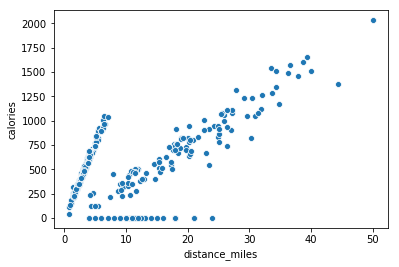

In [32]:
sns.scatterplot(activities['distance_miles'],activities['calories'])
plt.show()

Definitely some *almost* linear relationships going on. Is it related to the type of activity?

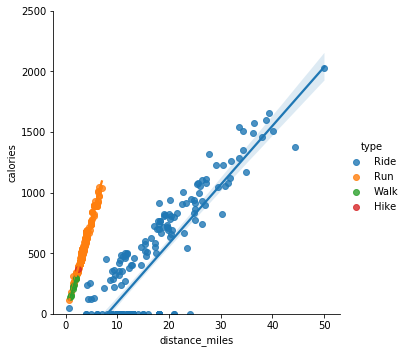

In [83]:
g = sns.lmplot(x="distance_miles", y="calories", hue="type",
               truncate=True, data=activities)
plt.ylim(0,2500)
plt.show()

Mostly related - run, walk, and hike all obey one type of logic and ride obeys a different logic. But what's with all of the riding activities where there are 0 calories?

In [85]:
#They're all trainer activities
activities.loc[(activities['calories']==0)&(activities['type']=='Ride'),:]

,id,date,name,type,description,elapsed_time,distance,commute,gear,filename,...,moving_time_seconds,distance_feet,distance_miles,manual,has_station,has_weather,has_file,indoor,new_type,other_athlete_count
169,1186521046,2017-09-15 15:30:00,Trainer Warmup/Cooldown,Ride,Was originally going to do a full ride on the ...,00:12:00,6437.38,False,Trainer,,...,720,21120.013799,4.000003,True,True,True,False,True,Ride,0.0
196,1214023374,2017-10-03 16:00:00,Spinning,Ride,"Spin class at work. First ever spin class, act...",00:45:00,24140.20,False,Trainer,,...,2700,79200.133768,15.000025,True,True,True,False,True,Ride,0.0
244,1494764901,2018-04-07 14:00:00,Trainer,Ride,Shortened my usual Saturday trainer ride since...,00:40:00,19312.10,False,Orbea,,...,2400,63359.910164,11.999983,True,True,True,False,True,Ride,0.0
245,1497661412,2018-04-08 13:00:00,Trainer,Ride,NaN,01:00:00,28968.20,False,Orbea,,...,3600,95040.029288,18.000006,True,True,True,False,True,Ride,0.0
250,1519401232,2018-04-18 21:00:00,Trainer,Ride,One day it'll be consistently nice outside,00:40:00,19312.10,False,Orbea,,...,2400,63359.910164,11.999983,True,True,True,False,True,Ride,0.0
251,1519401491,2018-04-19 22:00:00,Another Trainer Ride,Ride,NaN,00:34:00,16093.40,False,Orbea,,...,2040,52799.870456,9.999975,True,True,True,False,True,Ride,0.0
255,1529792224,2018-04-24 21:30:00,Back on the trainer,Ride,NaN,00:34:00,16093.40,False,Orbea,,...,2040,52799.870456,9.999975,True,True,True,False,True,Ride,0.0
258,1536937189,2018-04-28 13:00:00,Trainer,Ride,Didn't feel like riding in the rain,01:20:00,38624.30,False,Orbea,,...,4800,126720.148412,24.000028,True,True,True,False,True,Ride,0.0
290,971985144,2017-05-05 12:00:00,Morning Ride,Ride,Bike MS fundraiser in the lobby of my work - b...,00:45:00,24140.20,False,Trainer,,...,2700,79200.133768,15.000025,True,True,True,False,True,Ride,0.0
306,1554780672,2018-05-06 22:39:45,Trainer,Ride,"Easy trainer, legs are sore from yesterday. Ov...",00:30:00,14484.10,False,Orbea,,...,1800,47520.014644,9.000003,True,True,True,False,True,Ride,0.0


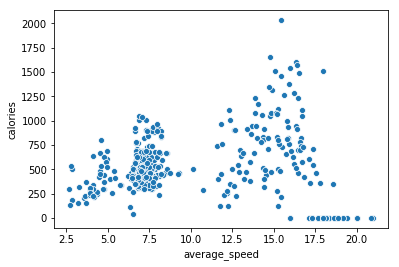

In [33]:
sns.scatterplot(activities['average_speed'],activities['calories'])
plt.show()

In [34]:
activities[activities['type']=='Ride'].corr()['calories'].sort_values(ascending=False).head(10)

#total_elevation_gain
#moving_time_seconds
#max_speed
#distance_miles

calories                1.000000
total_elevation_gain    0.917231
moving_time_seconds     0.895154
max_speed               0.871362
distance_miles          0.863736
distance                0.863736
distance_feet           0.863736
has_file                0.805677
TMAX                    0.631561
TMIN                    0.602499
Name: calories, dtype: float64

In [35]:
activities[activities['type']=='Run'].corr()['calories'].sort_values(ascending=False).head(10)

#total_elevation_gain
#moving_time_seconds
#max_speed
#distance_miles

calories                1.000000
distance_miles          0.988201
distance                0.988201
distance_feet           0.988201
moving_time_seconds     0.747454
total_elevation_gain    0.463237
achievement_count       0.404129
average_speed           0.333111
TMIN                    0.094405
kudos_count             0.087242
Name: calories, dtype: float64

Interestingly, for running calories are almost entirely correlated with distance

For cycling, calories are largely correlated with elevation, moving time, max_speed, and distance (all of which are  correlated amongst each other)

In [37]:
chk = ['total_elevation_gain','moving_time_seconds','max_speed','distance']

activities[activities['type']=='Ride'].corr()[chk].loc[chk,:]

,total_elevation_gain,moving_time_seconds,max_speed,distance
total_elevation_gain,1.000000,0.806530,0.802353,0.759940
moving_time_seconds,0.806530,1.000000,0.665893,0.968837
max_speed,0.802353,0.665893,1.000000,0.594031
distance,0.759940,0.968837,0.594031,1.000000


In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

x = activities.copy()
all_types = x['type'].unique()

cols_to_drop = ['name','description','filename','filename_fix','latlng']
x.drop(cols_to_drop,axis=1,inplace=True)

x = pd.get_dummies(x)

impute = x[(x['calories'].isnull())|(x['calories']==0)]
x = x[(~x['calories'].isnull())&(x['calories']!=0)]

y = x['calories']
x.drop('calories',axis=1,inplace=True)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cols = x.select_dtypes(numerics).columns

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(x[cols])
x[cols] = scaler.transform(x[cols])
impute[cols] = scaler.transform(impute[cols])

drop_cols = ['id','date', 'elapsed_time', 'moving_time', 'date_est']
x.drop(drop_cols,inplace=True,axis=1)

rf = RandomForestRegressor()
linreg = LinearRegression()
linear_ride_vars = ['distance_miles','max_speed','total_elevation_gain','moving_time_seconds']
linear_run_vars = ['distance_miles','moving_time_seconds']

for t in all_types:
    print(t)
    new_x = x[x['type_'+t]==1]
    if t == 'Ride':
        lin_x = new_x[linear_ride_vars]
    else:
        lin_x = new_x[linear_run_vars]
    new_y = y[new_x.index]
    n_splits = 10
    if new_x.shape[0] < 10:
        n_splits = new_x.shape[0]
    if n_splits == 1:
        continue
    kfold = KFold(n_splits=n_splits,random_state=2)
    results_rf = cross_val_score(rf, new_x, new_y, cv=kfold,scoring='r2')
    results_lr = cross_val_score(linreg, lin_x, new_y, cv=kfold,scoring='r2')
    print('Average R2: %2.2f%%'%(results_rf.mean()*100.0))
    print('Standard deviation: %2.2f%%'%(results_rf.std()*100.0))
    print('Linear average R2: %2.2f%%'%(results_lr.mean()*100.0))
    print('Linear standard deviation: %2.2f%%'%(results_lr.std()*100.0))
    print('')

Ride
Average R2: 87.25%
Standard deviation: 4.90%
Linear average R2: 94.77%
Linear standard deviation: 4.68%

Run
Average R2: 98.14%
Standard deviation: 0.97%
Linear average R2: 97.09%
Linear standard deviation: 1.09%

Walk
Average R2: 0.00%
Standard deviation: 0.00%
Linear average R2: 0.00%
Linear standard deviation: 0.00%

Hike


Interesting - a linear model does better for rides and worse for runs than a random forest. But, on the whole, I'm okay with being a few percentage points off where I'm missing data - I'll use a linear model

In [40]:
for t in all_types:
    new_x = x[x['type_'+t]==1]
    if t == 'Ride':
        lin_x = new_x[linear_ride_vars]
        imp = impute[impute['type_'+t]==1][linear_ride_vars]
    else:
        lin_x = new_x[linear_run_vars]
        imp = impute[impute['type_'+t]==1][linear_run_vars]
        
    if imp.shape[0] == 0:
        continue
        
    new_y = y[new_x.index]
    linreg = LinearRegression()
    linreg.fit(lin_x,new_y)
    imp['pred'] = linreg.predict(imp)
    impute.loc[imp.index,'pred'] = imp['pred']

In [46]:
i = impute.index

In [53]:
activities.loc[i,'calories'] = impute['pred']

Now that we've imputed the data, how does it look?

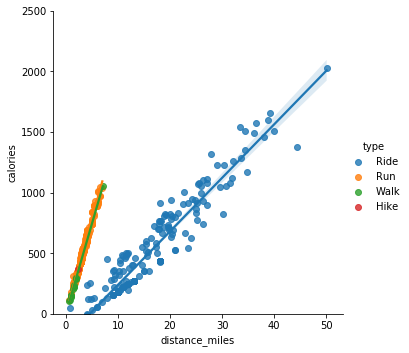

In [56]:
g = sns.lmplot(x="distance_miles", y="calories", hue="type",
               truncate=True, data=activities)
plt.ylim(0,2500)
plt.show()

Total elevation gain is returned with units (e.g. feet) so this needs to be converted to a float


We'll need to do the same for average and max speed as well

In [57]:
activities.select_dtypes(object)

,name,type,description,gear,filename,stationid,filename_fix,latlng,new_type
0,"Jun 26, 2012",Ride,NaN,NaN,activities/11823912.gpx,US1PAAL0046,Data/activities/GPX/11823912.gpx,"(40.475049, -79.918379)",Ride
1,"Jun 30, 2012",Ride,NaN,NaN,activities/12093460.gpx,US1PAAL0046,Data/activities/GPX/12093460.gpx,"(40.475199, -79.918298)",Ride
2,Morning Ride,Ride,NaN,Orbea,activities/57479962.gpx,US1PALZ0024,Data/activities/GPX/57479962.gpx,"(41.25183, -75.878021)",Ride
3,Larksville Mountain,Ride,NaN,Orbea,activities/58993417.gpx,US1PALZ0024,Data/activities/GPX/58993417.gpx,"(41.267812, -75.879984)",Ride
4,Sunday long run,Run,NaN,NaN,activities/162388804.fit.gz,USC00362574,Data/activities/GPX/162388804.gpx,"(40.512778415, -80.101835728)",Run
5,Stormy,Run,NaN,NaN,activities/163244768.fit.gz,USC00362574,Data/activities/GPX/163244768.gpx,"(40.499178441, -80.063069258)",Run
6,Hill Sprints (x7),Run,NaN,NaN,activities/165922709.fit.gz,USC00362574,Data/activities/GPX/165922709.gpx,"(40.501555633, -80.067974683)",Run
7,Workday Recovery,Run,NaN,NaN,activities/165922753.fit.gz,USW00094823,Data/activities/GPX/165922753.gpx,"(40.469825352, -80.212752195)",Run
8,Hill Sprints (x5),Run,NaN,NaN,activities/170841503.fit.gz,USC00362574,Data/activities/GPX/170841503.gpx,"(40.503410381, -80.072803749)",Run
9,Paul Richey 5K,Run,"2nd overall, 19:47 official time",NaN,activities/170841955.fit.gz,US1PAVN0005,Data/activities/GPX/170841955.gpx,"(41.411005371, -79.730279539)",Run


In [58]:
activities.head()

,id,date,name,type,description,elapsed_time,distance,commute,gear,filename,...,moving_time_seconds,distance_feet,distance_miles,manual,has_station,has_weather,has_file,indoor,new_type,other_athlete_count
0,11823912,2012-06-26 22:17:36,"Jun 26, 2012",Ride,NaN,01:35:28,32518.2,False,NaN,activities/11823912.gpx,...,5322,106687.011288,20.205873,False,True,False,True,False,Ride,1.0
1,12093460,2012-06-30 14:05:19,"Jun 30, 2012",Ride,NaN,01:54:06,39051.2,False,NaN,activities/12093460.gpx,...,6273,128120.739008,24.265291,False,True,False,True,False,Ride,0.0
2,57479962,2013-06-01 11:22:25,Morning Ride,Ride,NaN,02:38:45,51531.0,False,Orbea,activities/57479962.gpx,...,7379,169064.966040,32.019880,False,True,False,True,False,Ride,7.0
3,58993417,2013-06-08 11:20:05,Larksville Mountain,Ride,NaN,02:59:04,53837.0,False,Orbea,activities/58993417.gpx,...,7529,176630.583080,33.452762,False,True,False,True,False,Ride,5.0
4,148403154,2014-06-01 23:10:05,Sunday long run,Run,NaN,00:42:16,4809.8,False,NaN,activities/162388804.fit.gz,...,1448,15780.184232,2.988671,False,True,True,True,False,Run,0.0


# Data Cleaning and Prep

In [6]:
def lat_lng_to_zip(latlng,ztc):
    minrow = (np.sqrt((ztc['LAT'] - latlng[0])**2 + (ztc['LNG'] - latlng[1])**2)).values.argmin()
    return ztc.iloc[minrow]['ZIP']

#all activities have been converted to GPX using GPSBabel, so I need to fix the filenames
def parse_filename(filename):
    filename = filename.split('/')
    if len(filename) == 1:
        filename = None
    else:
        filename = filename[1]
    
    if filename is None:
        fn = ''
    elif filename[-4:] == '.gpx':
        fn = filename
    else:
        fn = filename[:-7] + '.gpx'
    return 'Data/activities/GPX/' + fn

def gpx_attributes(filename):
    try:
        with open(filename,'r') as gpx_file:
            #gpx_file = open(filename,'r')
            gpx = gpxpy.parse(gpx_file)
            first_pt = gpx.tracks[0].segments[0].points[0]
            start_pos = (first_pt.latitude,first_pt.longitude)
        ret = start_pos
    except:
        #if there's no file then it was manually input, 
        #which means I most likely rode on my trainer at home
        ret = (40.552273, -80.044383)
    return ret

Below are some helper functions:

* **lat_lng_to_zip**
    - Translates a given latitude and longitude into the nearest US zip code
* **parse_filename**
    - Removes the .fit.gz and replaces with .gpx for files which aren't identified as .gpx in the Strava data
* **gpx_attributes**
    - Figures out the latitude and longitude of the first point within a .gpx file

In [7]:
#load zip code data from https://gist.github.com/erichurst/7882666
converters={'ZIP': lambda x: str(x)}
ztc = pd.read_csv(data_path + 'zip_to_coord.txt',converters=converters)

In [8]:
activities['filename_fix'] = activities['filename'].apply(lambda x: parse_filename(x))
activities['latlng'] = activities['filename_fix'].apply(lambda x: gpx_attributes(x))
activities['zip'] = activities['latlng'].apply(lambda x: lat_lng_to_zip(x,ztc))

In [9]:
activities.head()

,id,date,name,type,description,elapsed_time,distance,commute,gear,filename,filename_fix,latlng,zip
0,11823912,2012-06-26 22:17:36,"Jun 26, 2012",Ride,NaN,5728,32518.2,False,NaN,activities/11823912.gpx,Data/activities/GPX/11823912.gpx,"(40.475049, -79.918379)",15206
1,12093460,2012-06-30 14:05:19,"Jun 30, 2012",Ride,NaN,6846,39051.2,False,NaN,activities/12093460.gpx,Data/activities/GPX/12093460.gpx,"(40.475199, -79.918298)",15206
2,12413019,2012-07-03 22:30:35,"Jul 3, 2012",Ride,NaN,5369,29010.3,False,Orbea,activities/12413019.gpx,Data/activities/GPX/12413019.gpx,"(40.486821, -79.894246)",15215
3,13691080,2012-07-17 22:22:28,Riverview Park,Ride,NaN,6273,37623.0,False,Orbea,activities/13691080.gpx,Data/activities/GPX/13691080.gpx,"(40.466192, -79.922708)",15206
4,14016843,2012-07-21 12:37:10,Forward Avenue,Ride,NaN,7436,36497.3,False,Orbea,activities/14016843.gpx,Data/activities/GPX/14016843.gpx,"(40.452901, -79.932796)",15232


In [31]:
activities.iloc[1]

id                                              12093460
date                                 2012-06-30 14:05:19
name                                        Jun 30, 2012
type                                                Ride
description                                          NaN
elapsed_time                                     1:54:06
distance                                         39051.2
commute                                            False
gear                                                 NaN
filename                         activities/12093460.gpx
filename_fix            Data/activities/GPX/12093460.gpx
latlng                           (40.475199, -79.918298)
zip                                                15206
athlete_count                                          1
achievement_count                                      2
comment_count                                          0
kudos_count                                            1
moving_time                    

# Nearest Stations

The NOAA API needs to have a station requested in order to be certain we get weather data. So, for each activity, we need to figure out which station was nearest to that activity

In [41]:
ghcnd_names = ['ID','LATITUDE','LONGITUDE','ELEVATION','STATE','NAME']
stations_g = pd.DataFrame(columns=ghcnd_names)
all_rows = []
with open(data_path + 'ghcnd-stations.txt','r') as file:
    ind = 0
    for row in file:
        if row[0:2]!='US':
            continue
        state = row[38:40].strip()
        name = row[41:71].strip()
        t = ' '.join(row.split())
        l = t.split(' ',maxsplit=5)
        all_rows.append(l)
        #stations_g.loc[ind] = l
        #ind += 1
stations_g = pd.DataFrame(all_rows,columns=ghcnd_names)

In [56]:
numeric = ['LATITUDE','LONGITUDE','ELEVATION']
for c in numeric:
    stations_g[c] = pd.to_numeric(stations_g[c])

In [50]:
stations_i = pd.read_csv(data_path + 'isd-history.csv',quotechar='"')
stations_i = stations_i[~stations_i['LAT'].isnull()]

In [62]:
def find_nearest_station(latlng,stations):
    minrow = (np.sqrt((stations_g['LATITUDE'] - latlng[0])**2 + (stations_g['LONGITUDE'] - latlng[1])**2)).values.argmin()
    return stations_g.iloc[minrow]['ID']

In [63]:
activities['stationid'] = activities['latlng'].apply(lambda x: find_nearest_station(x,stations_g))

In [147]:
def get_noaa_data_station(url,station,header):
    url = url + station
    r = requests.get(url,headers=header)
    return r
    
def construct_params_station(token,station_id):
    creds = dict(token=token)
    station = 'GHCND:%s'%station_id
    u = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/stations/'
    r = get_noaa_data_station(u,station,creds)
    return r

In [174]:
#some stations are no longer active - need to delete these
token = noaa_api_token.token
for s in activities['stationid'].unique():
    r = construct_params_station(token,s)
    rj = r.json()
    mnd = datetime.datetime.strptime(rj['mindate'], '%Y-%m-%d')
    mxd = datetime.datetime.strptime(rj['maxdate'], '%Y-%m-%d')
    #how many are within the date range? if 0, then remove from dataset
    ct = activities[(activities['stationid']==s)&(activities['date'] > mnd)&(activities['date'] < mxd)].count()['id']
    if ct == 0:
        print("REMOVED")
        stations_g = stations_g[stations_g['ID']!=s]
        activities[(activities['stationid']==s)]['stationid'] = None
    time.sleep(0.200)
        #remove station

In [173]:
activities['stationid'] = activities['latlng'].apply(lambda x: find_nearest_station(x,stations_g))

# Strava API

In [ ]:
#https://developers.strava.com/docs/reference/#api-Activities-getActivityById

In [158]:
from stravalib.client import Client
from stravalib import unithelper

In [159]:
client = Client()
authorize_url = client.authorization_url(client_id=26961, redirect_uri='127.0.0.1')
client.access_token = strava

In [26]:
#Create new columns for all of our interesting fields above
for i in strava_fields:
    activities[i] = None

In [ ]:
for ind,row in activities.iterrows():
    if not row.has_file or row.athlete_count is not None:
        continue
    try:
        activity = client.get_activity(row.id)
        if activity.resource_state != 3:
            continue
        for i in strava_fields:
            attr = getattr(activity,i)
            if i == 'total_elevation_gain':
                a = unithelper.feet(attr)
                #print(unithelper.feet(attr))
            elif i=='average_speed' or i=='max_speed':
                a = unithelper.mph(attr)
                #print(unithelper.mph(attr))
            else:
                a = attr
            activities.loc[ind,i] = a
    except:
        print('Failed')


In [59]:
indoor = activities[activities['indoor']==True]
missing = indoor.isnull().any()
print(missing[missing])
cols = list(missing[missing].index)

description    True
dtype: bool


In [195]:
for ind,row in indoor.iterrows():
    try:
        activity = client.get_activity(row.id)
    except:
        print('No activity found')
    for col in cols:
        try:
            attr = getattr(activity,col)
            if col == 'total_elevation_gain':
                a = unithelper.feet(attr).num
                #print(unithelper.feet(attr))
            elif col=='average_speed' or col=='max_speed':
                a = unithelper.mph(attr).num
            else:
                a = attr
            activities.loc[ind,col] = a
        except:
            pass
    

No such attribute available_zones on entity <Activity id=903844262 name='Bike trainer' resource_state=3>
No such attribute available_zones on entity <Activity id=920858052 name='Trainer Ride' resource_state=3>
No such attribute available_zones on entity <Activity id=971985144 name='Morning Ride' resource_state=3>
No such attribute available_zones on entity <Activity id=1186521046 name='Trainer Warmup/Cooldown' resource_state=3>
No such attribute available_zones on entity <Activity id=1214023374 name='Spinning' resource_state=3>
No such attribute available_zones on entity <Activity id=1264515201 name='Work Short Ride' resource_state=3>
No such attribute available_zones on entity <Activity id=1264516318 name='Lunch Ride' resource_state=3>
No such attribute available_zones on entity <Activity id=1264517543 name='Trainer Evening Ride' resource_state=3>
No such attribute available_zones on entity <Activity id=1272903132 name='Trainer Ride' resource_state=3>
No such attribute available_zones

No such attribute available_zones on entity <Activity id=1445701366 name='Trainer' resource_state=3>
No such attribute available_zones on entity <Activity id=1445704216 name='Trainer' resource_state=3>
No such attribute available_zones on entity <Activity id=1449330115 name='Early Trainer' resource_state=3>
No such attribute available_zones on entity <Activity id=1457414767 name='Trainer' resource_state=3>
No such attribute available_zones on entity <Activity id=1457415275 name='Trainer' resource_state=3>
No such attribute available_zones on entity <Activity id=1457416633 name='Morning Trainer' resource_state=3>
No such attribute available_zones on entity <Activity id=1459396401 name='Trainer' resource_state=3>
No such attribute available_zones on entity <Activity id=1469948748 name='Spin Class' resource_state=3>
No such attribute available_zones on entity <Activity id=1469949181 name='Trainer' resource_state=3>
No such attribute available_zones on entity <Activity id=1469949990 name='

No activity found
No activity found


In [60]:
activities['moving_time_seconds'] = activities['moving_time'].apply(lambda x: x.seconds)

In [61]:
activities['other_athlete_count'] = activities['athlete_count'] - 1

# Weather

In [22]:
import datetime
import requests
import time

ex_url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:28801&startdate=2010-05-01&enddate=2010-05-01'

def get_noaa_data(url,params, header):
    r = requests.get(url, params=params, headers=header)
    return r
    
def construct_params(token,station_id,start,end):
    creds = dict(token=token)
    params={}
    params['datasetid'] = 'GHCND'
    params['stationid'] = 'GHCND:%s'%station_id
    params['startdate'] = start
    params['enddate'] = end
    u = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data'
    r = get_noaa_data(u,params,creds)
    return r

def c_to_f(c):
    return c/10.0 * 9.0/5 + 32

def get_ranges(activity,token):
    loc = activity.stationid
    #assume start and end on same day - I'm not doing any multiday touring
    start = activity.date.strftime('%Y-%m-%d')
    end = start
    try:
        weather = construct_params(token,loc,start,end)
        tmax = None
        tmin = None
        precip = None
        for res in weather.json()['results']:
            if res['datatype']=='TMAX':
                tmax = c_to_f(res['value'])
            elif res['datatype'] == 'TMIN':
                tmin = c_to_f(res['value'])
            elif res['datatype']=='PRCP':
                precip = res['value']
        retdict = {'TMAX': tmax,'TMIN':tmin,'PRECIP':precip}
    except:
        retdict = {'TMAX': None,'TMIN':None,'PRECIP':None}
    return retdict

In [216]:
for index,row in activities.iterrows():
    #already have identified the temperature for this particular row
    if not np.isnan(row['TMAX']):
        continue
    r = get_ranges(row,token)
    activities.loc[index,'TMAX'] = r['TMAX']
    activities.loc[index,'TMIN'] = r['TMIN']
    activities.loc[index,'PRECIP'] = r['PRECIP']
    time.sleep(0.200)

In [189]:
activities.to_csv(data_path + 'activities_out.csv')

In [19]:
temp = activities[activities.has_weather]
temp = temp[temp['date'].apply(lambda x: x.year) >= 2016]

In [20]:
temp.loc[:,'TAVG'] = (temp.loc[:,'TMAX'] + temp.loc[:,'TMIN'])/2
temp.loc[:,'temp_bucket'] = np.floor(temp.loc[:,'TMAX']/10) * 10

In [21]:
temp.loc[:,'dist_ft'] = temp.loc[:,'distance'] * 3.2808399
temp.loc[:,'dist_mi'] = temp.loc[:,'dist_ft'] / 5280

In [22]:
temp.groupby('temp_bucket').sum()['dist_mi']

temp_bucket
10.0    102.648098
20.0     86.596508
30.0    311.060476
40.0    409.918843
50.0    341.087972
60.0    353.178811
70.0    406.677349
80.0    531.324211
90.0    124.382854
Name: dist_mi, dtype: float64

In [23]:
from scipy.interpolate import UnivariateSpline
import math
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.preprocessing import minmax_scale

In [23]:
x = temp.date
y = temp.TMAX
ind = temp.indoor
act_type = temp.new_type

xd = np.linspace(0,1,len(x))
xs = np.linspace(0,1,len(x)*3)

x_labels = x.apply(lambda j: j.strftime('%Y-%m'))
x_labels = np.stack([xd,x_labels])

new_tick_pos = x_labels[0][range(0,len(x),math.floor(len(x)/10))]
new_tick_labels = x_labels[1][range(0,len(x),math.floor(len(x)/10))]

In [24]:
#let's size the bubbles so that each bubble is sized relative to its activity type
temp_s = temp[['new_type','distance']]
mx = temp_s.groupby('new_type').max()
temp_s = temp_s.merge(mx,left_on='new_type',right_index=True)
temp_s['s'] = temp_s['distance_x']/temp_s['distance_y']

z = minmax_scale(temp_s.s)

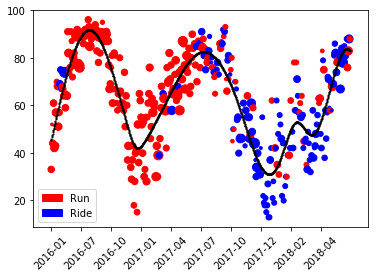

In [25]:
var_y = np.var(y)
len_y = len(y)
smoothing_factor = (var_y*len_y)*0.25

s = UnivariateSpline(xd, y,s=smoothing_factor)
ys = s(xs)

fig,ax = plt.subplots(1,1)

color_map = {True:'r',False:'b'}
color_map_act = {'Run':'r','Ride':'b'}
#colors = ind.apply(lambda x: color_map[x]).values
colors = act_type.apply(lambda x: color_map_act[x]).values
handles = []


for k,v in color_map_act.items():
    handles.append(mpatches.Patch(color=v,label=k))
    
#for k,v in color_map.items():
#    if k:
#        label = 'Indoor'
#    else:
#        label = 'Outdoor'
#    handles.append(mpatches.Patch(color=v,label=label))
    
ax.scatter(xd,y,c=colors,s=z*100)
ax.scatter(xs,ys,c='k',marker='.',s=4)
plt.xticks(new_tick_pos,new_tick_labels,rotation=45)
plt.legend(handles=handles)

plt.show()

# Map

In [204]:
from folium.plugins import HeatMap
import folium
import mplleaflet

In [20]:
#Looking to plot only the activities relatively close to Pittsburgh
ll = activities['latlng'].apply(lambda x: np.array(x))
ll = ll.apply(lambda x: x-np.array((40.466192, -79.922708)))
ll = ll.apply(lambda x: np.sum(np.power(x,2)))

In [21]:
def smooth_speed(point_num,segment,num_pts_to_smooth):
    start_point = point_num - num_pts_to_smooth
    end_point = point_num + num_pts_to_smooth + 1
    if start_point < 0:
        start_point = 0
    if end_point > len(segment.points):
        end_point = len(segment.points)
    n = end_point - start_point
    
    avg = 0
    for i in range(start_point,end_point - 1):
        cur_pt = segment.points[i]
        next_pt = segment.points[i+1]
        avg += cur_pt.speed_between(next_pt)
    return avg / n

In [200]:
def plot_activity(activity):
    fn = activity.filename_fix
    with open(fn,'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
        lat = []
        lng = []
        segment = gpx.tracks[0].segments[0]
        for point_no, pt in enumerate(segment.points):
            lat.append(pt.latitude)
            lng.append(pt.longitude)
    #plt.plot(lng, lat, color = 'deepskyblue', lw = 0.2, alpha = 0.8)
    return lat,lng

In [23]:
#Puts them into a list of lists
#activities_subset = activities[(activities['manual']==False)]
activities_subset = activities[(ll < 0.5)&(activities['manual']==False)]

all_lat = []
all_lng = []
act_type = []
for ind,row in activities_subset.iterrows():
    lat,lng = plot_activity(row)
    act_type.append(row.new_type)
    all_lat.append(lat)
    all_lng.append(lng)

In [24]:
fig = plt.figure(facecolor = '0.05',figsize=(20,20))
ax = plt.Axes(fig, [0., 0., 1., 1.], )
ax.set_aspect('equal')
ax.set_axis_off()
fig.add_axes(ax)
for i in range(len(all_lat)):
    lat = all_lat[i]
    lng = all_lng[i]
    a = act_type[i]
    if a=='Ride':
        plot_col = 'red'
    else:
        plot_col = 'blue'
    plt.plot(lng,lat, color = plot_col, lw = 2, alpha = 0.2)
mplleaflet.show(tiles='cartodb_positron')

# Trying to Use Quiver

In [44]:
import pyproj

In [45]:
fn = activities_subset.loc[0].filename_fix
with open(fn,'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

In [52]:
seg = gpx.tracks[0].segments[0]

In [99]:
y = [pt.latitude for pt in seg.points]
x = [pt.longitude for pt in seg.points]
speed = [seg.get_speed(i) for i in range(len(seg.points))]
speed = np.array(speed)

In [56]:
proj_in = pyproj.Proj(preserve_units=True, init='epsg:4326', no_defs=True)
crs_out = {'init': 'epsg:26986', 'no_defs': True}
proj_out = pyproj.Proj(preserve_units=True, **crs_out)
t = pyproj.transform(proj_in, proj_out, x, y)

In [93]:
from math import radians, degrees,cos, sin, asin, sqrt, atan2

def bearing(pt_one, pt_two):
    lat1, lon1 = map(radians,pt_one)
    lat2, lon2 = map(radians,pt_two)
    
    dL = lon2 - lon1
    x = cos(lat2) * sin(dL)
    y = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(dL)
    b = atan2(x,y)
    return b

In [110]:
#Calculating bearing between two points
pt_one=[39.099912, -94.581213]
pt_two=[38.627089, -90.200203]

h = bearing(pt_one,pt_two)

In [100]:
bearings = []
for i in range(len(y)):
    pt_one = [y[i],x[i]]
    try:
        pt_two = [y[i+1],x[i+1]]
    except:
        pt_two = pt_one
    bearings.append(bearing(pt_one,pt_two))
bearings = np.array(bearings)

In [115]:
r = speed / max(speed)
uv = r[:, np.newaxis] * np.column_stack([np.sin(bearings), np.cos(bearings)])

In [128]:
mapfile = 'strava_quiver.html'

plt.quiver(x, y, uv[:,0], uv[:,1], speed,scale=20)
mplleaflet.show(path=mapfile,tiles='cartodb_positron')

# Speed and Smoothing

In [48]:
pt = []
x = []
smoothed_x = []

for track in gpx.tracks:
    for segment in track.segments:
        for point_no, point in enumerate(segment.points):
            pt.append(point_no)
            x.append(point.speed_between(segment.points[point_no - 1]))
            smoothed_x.append(smooth_speed(point_no,segment,5))
#             print('Point at ({0},{1}) -> {2}'.format(point.latitude, point.longitude, point.elevation))

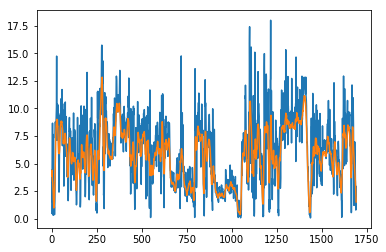

In [49]:
plt.plot(pt,x)
plt.plot(pt,smoothed_x)
plt.show()

# Strava Attributes

In [62]:
import seaborn as sns

In [63]:
biking = activities[activities['new_type']=='Ride']

In [64]:
biking.head()

,id,date,name,type,description,elapsed_time,distance,commute,gear,filename,...,moving_time_seconds,distance_feet,distance_miles,manual,has_station,has_weather,has_file,indoor,new_type,other_athlete_count
0,11823912,2012-06-26 22:17:36,"Jun 26, 2012",Ride,NaN,01:35:28,32518.2,False,NaN,activities/11823912.gpx,...,5322,106687.011288,20.205873,False,True,False,True,False,Ride,1.0
1,12093460,2012-06-30 14:05:19,"Jun 30, 2012",Ride,NaN,01:54:06,39051.2,False,NaN,activities/12093460.gpx,...,6273,128120.739008,24.265291,False,True,False,True,False,Ride,0.0
2,57479962,2013-06-01 11:22:25,Morning Ride,Ride,NaN,02:38:45,51531.0,False,Orbea,activities/57479962.gpx,...,7379,169064.966040,32.019880,False,True,False,True,False,Ride,7.0
3,58993417,2013-06-08 11:20:05,Larksville Mountain,Ride,NaN,02:59:04,53837.0,False,Orbea,activities/58993417.gpx,...,7529,176630.583080,33.452762,False,True,False,True,False,Ride,5.0
35,1031765759,2017-06-11 13:00:43,Morning Ride with Friends,Ride,NaN,02:02:07,37719.6,False,Orbea,activities/1134789725.fit.gz,...,6572,123751.972464,23.437874,False,True,False,True,False,Ride,1.0


In [65]:
biking.describe()

,id,elapsed_time,distance,athlete_count,achievement_count,comment_count,kudos_count,moving_time,total_elevation_gain,average_speed,...,TMAX,TMIN,PRECIP,zip,year,month,moving_time_seconds,distance_feet,distance_miles,other_athlete_count
count,2.160000e+02,216,216.000000,216.000000,216.000000,216.000000,216.000000,216,216.000000,216.000000,...,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000
mean,1.017120e+09,0 days 01:08:27.782407,26079.583333,1.620370,2.152778,0.101852,2.041667,0 days 01:01:55.902777,591.257222,16.254910,...,61.612083,39.807917,18.421296,15478.050926,2016.458333,6.087963,3715.902778,85562.940183,16.205102,0.620370
std,5.488606e+08,0 days 00:43:50.458586,13618.368698,2.423596,4.147265,0.384340,2.535905,0 days 00:35:18.776339,783.261761,2.268657,...,20.469688,17.578383,50.970519,1356.309858,1.918848,3.435335,2118.776339,44679.688758,8.462062,2.423596
min,1.182391e+07,0 days 00:11:05,1202.200000,1.000000,0.000000,0.000000,0.000000,0 days 00:06:51,0.000000,6.540000,...,12.920000,-5.980000,0.000000,1085.000000,2012.000000,1.000000,411.000000,3944.225848,0.747012,0.000000
25%,5.211019e+08,0 days 00:34:00,16093.400000,1.000000,0.000000,0.000000,0.000000,0 days 00:34:00,0.000000,14.845000,...,44.735000,28.040000,0.000000,15233.000000,2015.750000,3.000000,2040.000000,52799.870456,9.999975,0.000000
50%,1.286322e+09,0 days 00:51:47.500000,20921.500000,1.000000,0.000000,0.000000,1.000000,0 days 00:48:37.500000,117.455000,17.165000,...,66.020000,42.080000,0.000000,15237.000000,2017.000000,5.000000,2917.500000,68640.094060,13.000018,0.000000
75%,1.418903e+09,0 days 01:34:52.750000,32283.975000,1.000000,2.000000,0.000000,3.000000,0 days 01:20:12.500000,1161.250000,18.000626,...,80.960000,55.940000,5.750000,15237.000000,2018.000000,9.000000,4812.500000,105918.556539,20.060333,0.000000
max,1.600810e+09,0 days 03:28:00,80588.300000,30.000000,20.000000,3.000000,12.000000,0 days 03:14:51,4166.670000,21.000358,...,91.940000,69.080000,457.000000,18709.000000,2018.000000,12.000000,11691.000000,264397.318172,50.075250,29.000000


In [66]:
biking.groupby('athlete_count').agg({'count','mean','max','sum'})[['distance_miles','kudos_count']]

distance_miles                             kudos_count        \
                         sum count        max       mean         sum count   
athlete_count                                                                
1.0              2729.014704   185  50.075250  14.751431       356.0   185   
2.0               148.227668     8  27.010820  18.528458         8.0     8   
3.0               131.592690     5  34.341820  26.318538        10.0     5   
4.0               115.488799     4  38.747963  28.872200         9.0     4   
6.0               170.041277     6  33.452762  28.340213         9.0     6   
7.0                96.891283     4  27.117199  24.222821        28.0     4   
8.0                98.359086     3  40.027118  32.786362        21.0     3   
30.0               10.686591     1  10.686591  10.686591         0.0     1   

                               
                max      mean  
athlete_count                  
1.0            10.0  1.924324  
2.0             5.0  1.000000  
3.0            10.0  2.000000  
4.0             7.0  2.250000  
6.0             6.0  1.500000  
7.0             8.0  7.000000  
8.0            12.0  7.000000  
30.0            0.0  0.000000

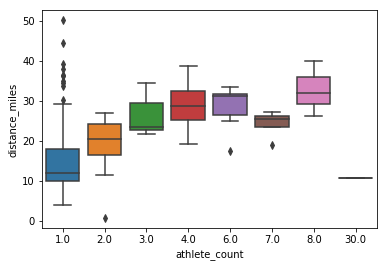

In [67]:
sns.boxplot(x='athlete_count',y='distance_miles',data=biking)
plt.show()

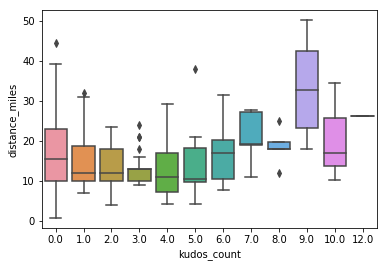

In [68]:
sns.boxplot(x='kudos_count',y='distance_miles',data=biking)
plt.show()

In [69]:
biking['achievement_count'].fillna(0,inplace=True)
biking['kudos_count'].fillna(0,inplace=True)

C:\Users\Rich\Anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


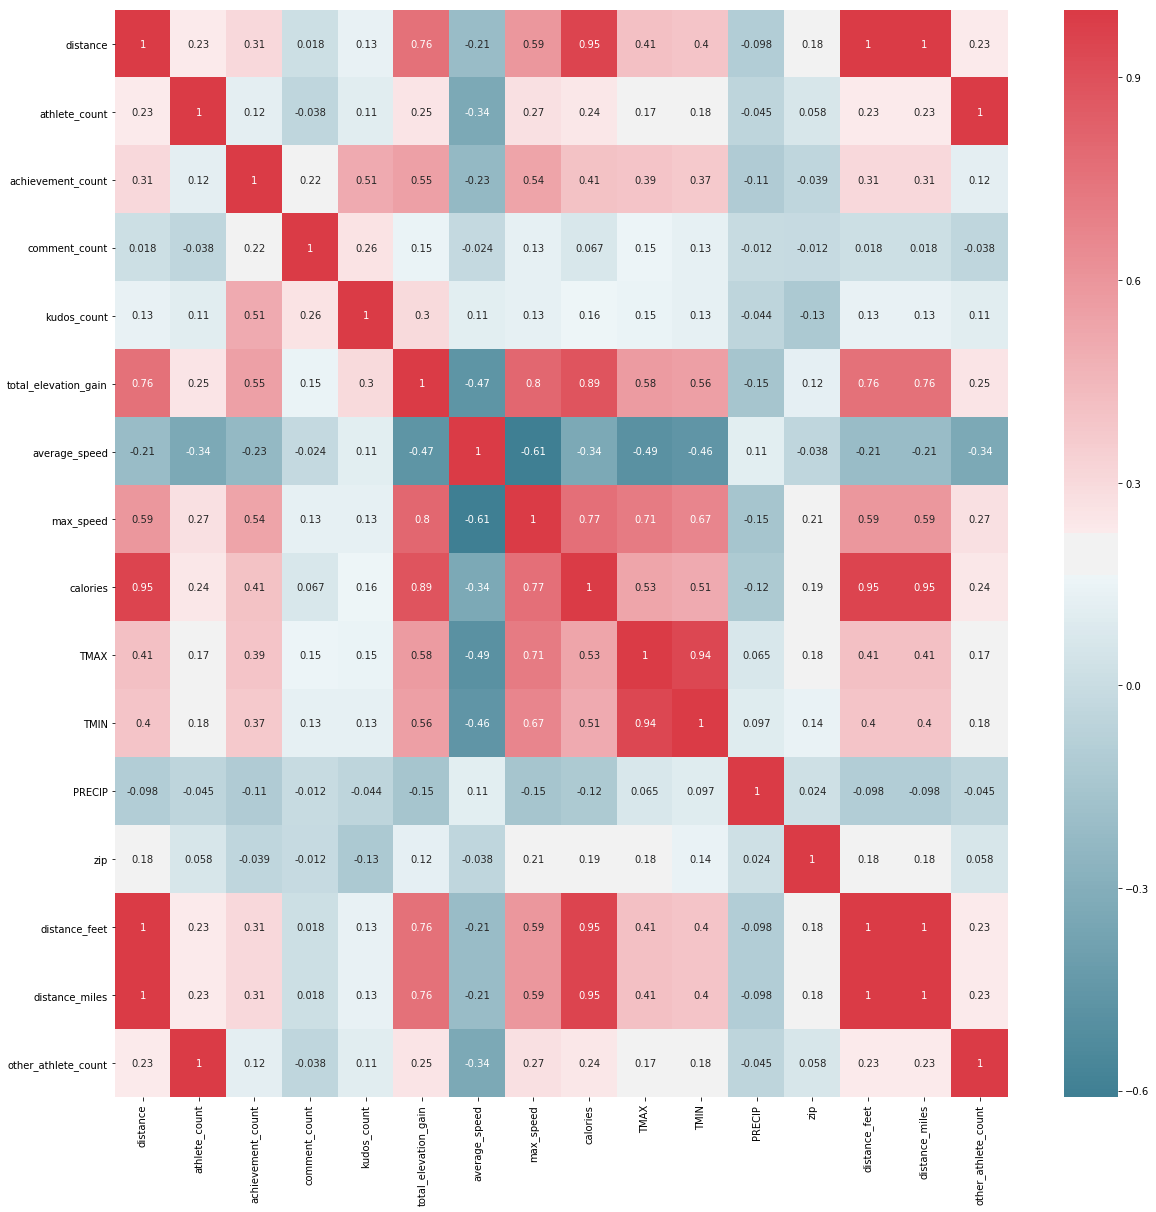

In [70]:
corr_set = biking.select_dtypes('float64')

c = corr_set.corr()
c = c[~c.isnull()]

fig,ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(c,ax=ax,cmap=cmap,annot=True)
plt.show()

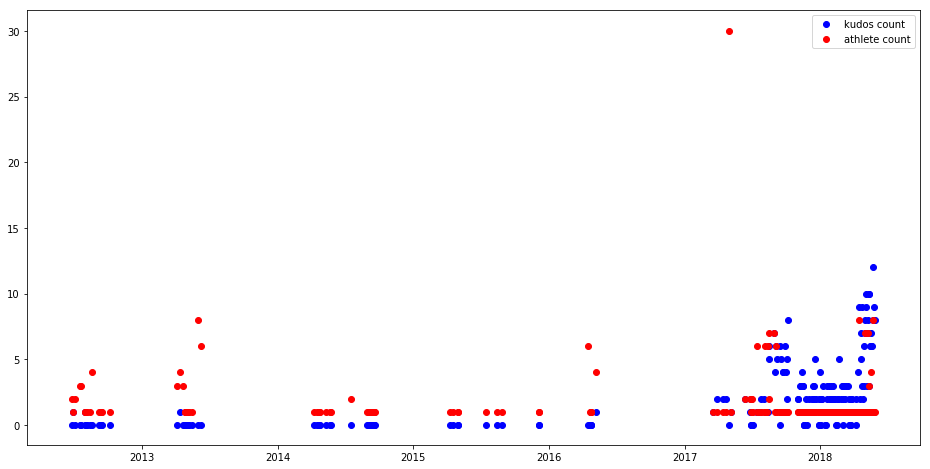

In [71]:
fig,ax = plt.subplots(figsize=(16,8))

x = biking['date'].apply(lambda x: pd.to_datetime(x)).values
y = biking['kudos_count'].values
y2 = biking['athlete_count'].values

ax.scatter(x,y,c='b',label='kudos count')
ax.scatter(x,y2,c='r',label='athlete count')
ax.legend()
plt.show()

Is there any relationship between distance and time of day or athlete count and time of day?

In [72]:
time_of_day = biking[['date_est','distance_miles','other_athlete_count']]
time_of_day.loc[:,'hour'] = time_of_day.loc[:,'date_est'].apply(lambda x: x.hour)

C:\Users\Rich\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Rich\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [73]:
gb = time_of_day.groupby('hour',as_index=False).agg({'count','sum','mean'})[['other_athlete_count','distance_miles']]
gb.columns = list(map('_'.join, gb.columns.values))
gb = gb.reset_index()

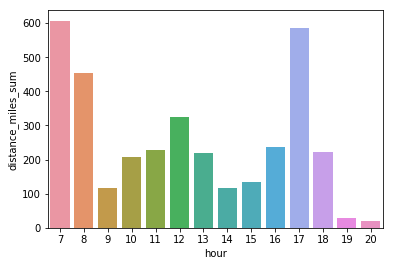

In [74]:
sns.barplot(x='hour',y='distance_miles_sum',data=gb)
plt.show()

It makes sense that I would ride less during the day (have to go to work most days, after all). But what if I look at this by day?

In [80]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
def date_to_string(date):
    return days[date.weekday()]

time_of_day['day_string'] = time_of_day['date_est'].apply(lambda x: date_to_string(x))

C:\Users\Rich\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


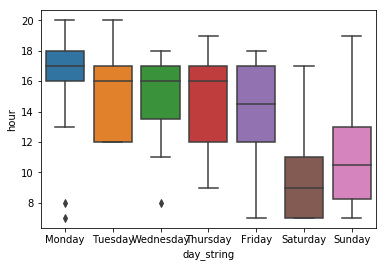

In [84]:
sns.boxplot(x='day_string',y='hour',data=time_of_day,order=days)
plt.show()

I prefer to ride late during the week and early on the weekend (though later on Sunday than on Saturday).

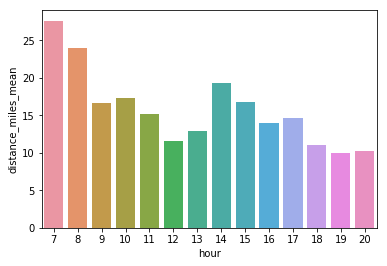

In [85]:
sns.barplot(x='hour',y='distance_miles_mean',data=gb)
plt.show()

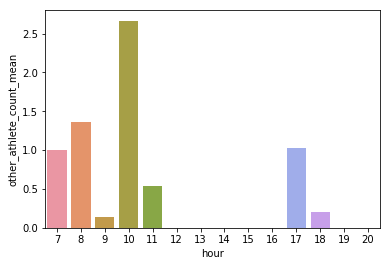

In [47]:
sns.barplot(x='hour',y='other_athlete_count_mean',data=gb)
plt.show()

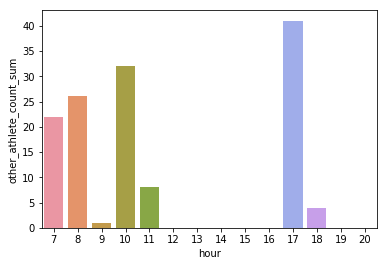

In [48]:
sns.barplot(x='hour',y='other_athlete_count_sum',data=gb)
plt.show()

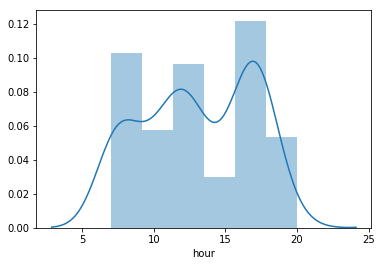

In [49]:
x = time_of_day['hour']

sns.distplot(x)
plt.show()

# Machine Learning

In [101]:
import xgboost
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [38]:
#predictors = ['athlete_count','distance_miles','elapsed_time','gear','total_elevation_gain','average_speed','TMAX','PRECIP']
target = 'kudos_count'

In [32]:
train_df = biking.copy()

In [33]:
num_unique = train_df.select_dtypes('object').apply(pd.Series.nunique,axis=0)
print(num_unique)

name            126
type              1
description      46
gear              2
filename        112
stationid        12
filename_fix    112
latlng          112
new_type          1
dtype: int64


Here are some columns that probably won't help us:

* Name
* Description
* Latitude or Longitude
* Filename
* Type or New_Type (only 1 value)

Gear on the other hand might - trainer vs. Orbea? And stationid has few enough that we can encode without causing too many issues

In [34]:
cols_to_drop = ['name','type','new_type','description','filename','filename_fix','latlng']

train_df.drop(cols_to_drop,axis=1,inplace=True)

We also have some boolean values - let's convert those to int

In [35]:
cols = train_df.select_dtypes('bool').columns
train_df.loc[:,cols] = train_df.loc[:,cols].astype(object)

Our xgboost algorithm won't be able to deal with object data, so let's 1-hot encode those columns

In [36]:
train_df = pd.get_dummies(train_df)

In [39]:
train_corr = train_df.corr().loc[:,target].sort_values()
train_corr.head(10)

has_weather_False       -0.275741
stationid_US1PALZ0024   -0.206052
stationid_US1PAAL0046   -0.193311
zip                     -0.129570
stationid_US1PAVN0005   -0.104164
PRECIP                  -0.084880
stationid_USC00368888   -0.078013
indoor_True             -0.070804
has_file_False          -0.070804
manual_True             -0.070804
Name: kudos_count, dtype: float64

What's going on with those last few columns?

In [40]:
null_corr = list(train_corr[train_corr.isnull()].index)
train_df.loc[:,null_corr].apply(pd.Series.nunique,axis=0)

commute_False       1
has_station_True    1
dtype: int64

In [41]:
train_df.drop(['commute_False','has_station_True'],axis=1,inplace=True)

We're missing some weather data - we may need to impute?

Missing 54 rows worth of weather data. I'll impute by year and month first, then by month if I still have NaN. I'll do this for TMIN and TMAX - if PRECIP is missing I'll assume it's 0.

In [85]:
print_missing(train_df)

athlete_count          True
comment_count          True
average_speed          True
max_speed              True
calories               True
moving_time_seconds    True
other_athlete_count    True
dtype: bool


In [43]:
med_yrmnth = train_df.groupby(by=['year','month'])['TMAX','TMIN','PRECIP'].agg(['median','mean']).reset_index()
med_mnth = train_df.groupby(by=['month'])['TMAX','TMIN','PRECIP'].agg(['median','mean']).reset_index()

In [44]:
med_yrmnth.columns = list(map('_'.join, med_yrmnth.columns.values))
med_mnth.columns = list(map('_'.join, med_mnth.columns.values))

In [46]:
train_df = train_df.merge(med_yrmnth,left_on=['year','month'],right_on=['year_','month_'],suffixes=('','_yrmnth'))
train_df = train_df.merge(med_mnth,left_on=['month'],right_on=['month_'],suffixes=('','_month'))

In [47]:
train_df.loc[train_df['TMAX'].isnull(),'TMAX'] = train_df.loc[train_df['TMAX'].isnull(),'TMAX_median']
train_df.loc[train_df['TMIN'].isnull(),'TMIN'] = train_df.loc[train_df['TMIN'].isnull(),'TMIN_median']
train_df.loc[train_df['PRECIP'].isnull(),'PRECIP'] = 0

train_df.loc[train_df['TMAX'].isnull(),'TMAX'] = train_df.loc[train_df['TMAX'].isnull(),'TMAX_median_month']
train_df.loc[train_df['TMIN'].isnull(),'TMIN'] = train_df.loc[train_df['TMIN'].isnull(),'TMIN_median_month']
train_df.loc[train_df['PRECIP'].isnull(),'PRECIP'] = 0

Let's get rid of the imputation columns

In [48]:
drop_cols = ['year_', 'month_', 'TMAX_median', 'TMAX_mean', 'TMIN_median',
    'TMIN_mean', 'PRECIP_median', 'PRECIP_mean', 'month__month',
    'TMAX_median_month', 'TMAX_mean_month', 'TMIN_median_month',
    'TMIN_mean_month', 'PRECIP_median_month', 'PRECIP_mean_month']

train_df.drop(drop_cols,axis=1,inplace=True)

No need to train on our target variable

In [73]:
train_df.drop(target,axis=1,inplace=True)

# Polynomial Features

Let's add in some polynomial features as well, see if those help anything

In [445]:
from sklearn.preprocessing import PolynomialFeatures

In [457]:
pf_cols = ['id','average_speed','max_speed','distance_miles','calories','total_elevation_gain']
pf_df = train_df.loc[:,pf_cols]

id_col = pf_df['id']
pf_df = pf_df.drop('id',axis=1)

pt = PolynomialFeatures(3,include_bias=True,interaction_only=False)
feats = pt.fit_transform(pf_df)
names = pt.get_feature_names(input_features = pf_cols[1:])
poly_features = pd.DataFrame(feats,columns=names)

In [459]:
poly_features['TARGET'] = biking[target]
poly_features['id'] = id_col

In [460]:
poly_features.corr()['TARGET'].sort_values().nsmallest(10)

average_speed                     -0.214899
average_speed^2                   -0.180777
average_speed^3                   -0.155448
average_speed^2 distance_miles    -0.104365
average_speed distance_miles      -0.099169
distance_miles                    -0.090181
distance_miles^3                  -0.088119
total_elevation_gain^3            -0.085652
calories total_elevation_gain^2   -0.083191
calories^3                        -0.083096
Name: TARGET, dtype: float64

The original features are already in our training set so no need to reincorporate

In [461]:
poly_features.drop(pf_cols[1:],axis=1,inplace=True)
poly_features.drop('TARGET',axis=1,inplace=True)

In [462]:
train_df = train_df.merge(poly_features,on='id',how='inner').sort_values(by='id')

# XGBoost

In [86]:
train_df.drop('id',inplace=True,axis=1)

NameError: name 'train_df' is not defined

In [ ]:
target_df = biking[target]
xgb1 = xgboost.sklearn.XGBClassifier(
 learning_rate =0.3,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

I'll apply a scaler to the (some of) the data as well

In [87]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cols = train_df.select_dtypes(numerics).columns

NameError: name 'train_df' is not defined

In [77]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(train_df[cols])
train_df[cols] = scaler.transform(train_df[cols])

Get rid of time columns - can't fit on them anyways

In [78]:
drop_cols = ['date', 'elapsed_time', 'moving_time', 'date_est']
train_df.drop(drop_cols,inplace=True,axis=1)

In [79]:
xgb1.fit(train_df,target_df,eval_metric='rmse')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [80]:
dtrain_predictions = xgb1.predict(train_df)

In [81]:
print("Accuracy : %.4f" % metrics.accuracy_score(target_df.values, dtrain_predictions))

Accuracy : 1.0000


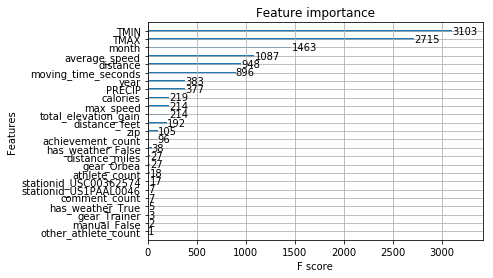

In [82]:
xgboost.plot_importance(xgb1)

What great accuracy! 100% accurate. What obvious problems are there with this?

Overfitting is the biggest issue - and comparing predictions within the set used for training
So, let's split into train and test, and see how well we do.

In [83]:
X_train, X_test, y_train, y_test = train_test_split(train_df, target_df, test_size=0.33, random_state=2)

In [84]:
xgb1.fit(X_train,y_train,eval_metric='rmse')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [85]:
p_test = xgb1.predict(X_test)

In [86]:
print("Accuracy : %.4f"%metrics.accuracy_score(y_test.values, p_test))

Accuracy : 0.4444


In [101]:
pred_df = pd.DataFrame(np.stack((y_test,p_test),axis=1),columns=['actual','predicted'])

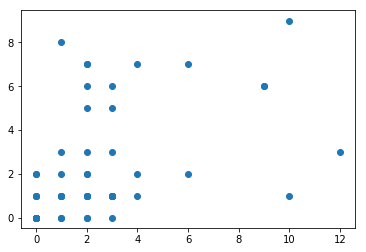

In [104]:
plt.scatter(pred_df['actual'],pred_df['predicted'])
plt.show()

We can also cross-validate - this is similar to train/test split, but run multiple times

In [87]:
kfold = KFold(n_splits=10,random_state=2)
results = cross_val_score(xgb1, train_df, target_df, cv=kfold)

In [88]:
print('Cross-validation accuracy: mean %0.2f%%, std %0.2f%%'%(results.mean()*100.0,results.std()*100.0))

Cross-validation accuracy: mean 31.15%, std 30.57%


Well that isn't great! But it's also not surprising - I don't have many activities and a lot of them are indoors over the winter (so they're guaranteed to get 0 kudos).

In [105]:
train_df.shape

(216, 40)

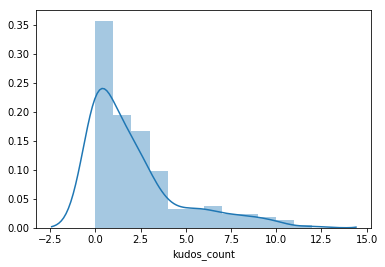

In [106]:
sns.distplot(target_df)
plt.show()

# Bike vs Run

In [128]:
train_df = activities.copy()
cols_to_drop = ['name','type','description','filename','filename_fix','latlng']
train_df.drop(cols_to_drop,axis=1,inplace=True)

cols = train_df.select_dtypes('bool').columns
train_df.loc[:,cols] = train_df.loc[:,cols].astype(object)

train_df['is_ride'] = train_df['new_type']=='Ride'
train_df = pd.get_dummies(train_df)
train_df.drop(['commute_False','has_station_True'],axis=1,inplace=True)

target = 'new_type_Ride'
target_df = train_df[target]
train_df.drop(['new_type_Ride','new_type_Run'],axis=1,inplace=True)

In [133]:
med_yrmnth = train_df.groupby(by=['year','month'])['TMAX','TMIN','PRECIP'].agg(['median','mean']).reset_index()
med_mnth = train_df.groupby(by=['month'])['TMAX','TMIN','PRECIP'].agg(['median','mean']).reset_index()

In [134]:
med_yrmnth.columns = list(map('_'.join, med_yrmnth.columns.values))
med_mnth.columns = list(map('_'.join, med_mnth.columns.values))

In [135]:
train_df = train_df.merge(med_yrmnth,left_on=['year','month'],right_on=['year_','month_'],suffixes=('','_yrmnth'))
train_df = train_df.merge(med_mnth,left_on=['month'],right_on=['month_'],suffixes=('','_month'))

In [136]:
train_df.loc[train_df['TMAX'].isnull(),'TMAX'] = train_df.loc[train_df['TMAX'].isnull(),'TMAX_median']
train_df.loc[train_df['TMIN'].isnull(),'TMIN'] = train_df.loc[train_df['TMIN'].isnull(),'TMIN_median']
train_df.loc[train_df['PRECIP'].isnull(),'PRECIP'] = 0

train_df.loc[train_df['TMAX'].isnull(),'TMAX'] = train_df.loc[train_df['TMAX'].isnull(),'TMAX_median_month']
train_df.loc[train_df['TMIN'].isnull(),'TMIN'] = train_df.loc[train_df['TMIN'].isnull(),'TMIN_median_month']
train_df.loc[train_df['PRECIP'].isnull(),'PRECIP'] = 0

Let's get rid of the imputation columns

In [137]:
drop_cols = ['year_', 'month_', 'TMAX_median', 'TMAX_mean', 'TMIN_median',
    'TMIN_mean', 'PRECIP_median', 'PRECIP_mean', 'month__month',
    'TMAX_median_month', 'TMAX_mean_month', 'TMIN_median_month',
    'TMIN_mean_month', 'PRECIP_median_month', 'PRECIP_mean_month']

train_df.drop(drop_cols,axis=1,inplace=True)

In [138]:
train_df.head()

,id,date,elapsed_time,distance,athlete_count,achievement_count,comment_count,kudos_count,moving_time,total_elevation_gain,...,stationid_USW00014775,stationid_USW00094823,manual_False,manual_True,has_weather_False,has_weather_True,has_file_False,has_file_True,indoor_False,indoor_True
0,11823912,2012-06-26 22:17:36,01:35:28,32518.2,2.0,1.0,0.0,0.0,01:28:42,1318.24,...,0,0,1,0,1,0,0,1,1,0
1,12093460,2012-06-30 14:05:19,01:54:06,39051.2,1.0,2.0,0.0,1.0,01:44:33,1209.32,...,0,0,1,0,1,0,0,1,1,0
2,57479962,2013-06-01 11:22:25,02:38:45,51531.0,8.0,2.0,0.0,0.0,02:02:59,1049.54,...,0,0,1,0,1,0,0,1,1,0
3,58993417,2013-06-08 11:20:05,02:59:04,53837.0,6.0,3.0,0.0,0.0,02:05:29,2169.95,...,0,0,1,0,1,0,0,1,1,0
4,148403154,2014-06-01 23:10:05,00:42:16,4809.8,1.0,0.0,0.0,0.0,00:24:08,374.02,...,0,0,1,0,0,1,0,1,1,0


In [139]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cols = train_df.select_dtypes(numerics).columns

In [140]:
print_missing(train_df)

Series([], dtype: bool)


In [141]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(train_df[cols])
train_df[cols] = scaler.transform(train_df[cols])

Get rid of time columns - can't fit on them anyways

In [142]:
drop_cols = ['date', 'elapsed_time', 'moving_time', 'date_est']
train_df.drop(drop_cols,inplace=True,axis=1)

In [143]:
train_df.drop('is_ride',inplace=True,axis=1)

In [144]:
xgb1 = xgboost.sklearn.XGBClassifier(
 learning_rate =0.3,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

kfold = KFold(n_splits=10,random_state=2)
results = cross_val_score(xgb1, train_df, target_df, cv=kfold)

In [167]:
print(y_train.shape,y_test.shape)

(349,) (172,)


In [146]:
X_train, X_test, y_train, y_test = train_test_split(train_df, target_df, test_size=0.33, random_state=2)

In [105]:
xgb1.fit(X_train,y_train,eval_metric='rmse')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [106]:
p_test = xgb1.predict(X_test)

In [107]:
print("Accuracy : %.4f"%metrics.accuracy_score(y_test.values, p_test))

Accuracy : 0.9942


In [108]:
pred_df = pd.DataFrame(np.stack((y_test,p_test),axis=1),columns=['actual','predicted'])

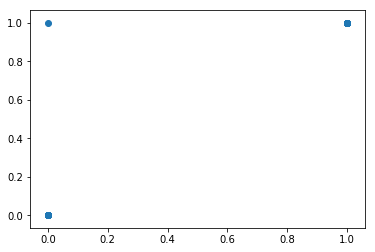

In [109]:
plt.scatter(pred_df['actual'],pred_df['predicted'])
plt.show()

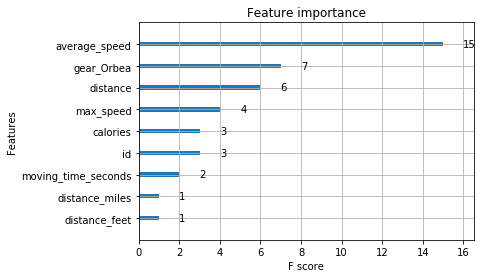

In [110]:
xgboost.plot_importance(xgb1)

In [182]:
pred_df[pred_df['actual']!=pred_df['predicted']]

,actual,predicted
140,0,1


In [197]:
X_test.iloc[140]
ind = train_df[train_df.id <= 0.179699].sort_values(by='id').tail(1).index
a = activities.iloc[ind]
a.iloc[0]

id                                                297474871
date                                    2015-04-25 15:05:19
name                    04/25/2015 Pittsburgh, Pennsylvania
type                                                    Run
description                                             NaN
elapsed_time                                0 days 01:24:53
distance                                            10524.4
commute                                               False
gear                                                    NaN
filename                        activities/336562772.fit.gz
athlete_count                                             1
achievement_count                                         6
comment_count                                             0
kudos_count                                               0
moving_time                                 0 days 00:33:06
total_elevation_gain                                 105.97
average_speed                           

This is the one that it mispredicted - or did it?

In [202]:
lat,lng = plot_activity(a.iloc[0])

In [208]:
fig = plt.figure(facecolor = '0.05',figsize=(10,10))
ax = plt.Axes(fig, [0., 0., 1., 1.], )
ax.set_aspect('equal')
ax.set_axis_off()
fig.add_axes(ax)
plot_col = 'Red'
plt.plot(lng,lat, color = plot_col, lw = 2, alpha = 1)
mplleaflet.display(tiles='cartodb_positron')

That looks an awful lot like it starts at East End Brewing Company and ends up there as well. As it happens, the EEBC Keg Ride was that day and I helped to marshal it (on my bike). So, the classifier actually was right and I misclassified it in Strava